In [191]:
!pip install -r requirements.txt

In [124]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor

import numpy as np
from scipy.stats import uniform, randint

import shap
import matplotlib.pyplot as plt

import random
import time
import json



In [27]:
#filepath = 'data_output/district_splits/SLOUGH.parquet'
filepath = 'data_output/clean_features.parquet'
features = pd.read_parquet(filepath)

In [28]:
features.head()

,CORE_price_paid,CORE_deed_date,1HE_district,BACKUP_county,ID_combined_address_x,ID_fuzzy_match,CORE_match_confidence,CORE_BUILDING_REFERENCE_NUMBER,1HE_CURRENT_ENERGY_RATING,1HE_POTENTIAL_ENERGY_RATING,...,AI_MAINHEAT_DESCRIPTION,1HE_MAINHEAT_ENERGY_EFF,AI_MAINHEATCONT_DESCRIPTION,1HE_MAINHEATC_ENERGY_EFF,AI_LIGHTING_DESCRIPTION,1HE_LIGHTING_ENERGY_EFF,1HE_MECHANICAL_VENTILATION,BACKUP_CONSTRUCTION_AGE_BAND,1HE_TENURE,ID_combined_address_y
0,582000,2022-06-06,BUCKINGHAMSHIRE,BUCKINGHAMSHIRE,49 amersham road nan hp13 5aa,49 amersham road hp13 5aa,92.592593,5.175796e+09,D,B,...,"Boiler and radiators, mains gas",Good,"Programmer, room thermostat and TRVs",Good,Low energy lighting in 73% of fixed outlets,Very Good,natural,England and Wales: 1900-1929,Owner Occupied,49 amersham road hp13 5aa
1,582000,2022-06-06,BUCKINGHAMSHIRE,BUCKINGHAMSHIRE,49 amersham road nan hp13 5aa,49 amersham road hp13 5aa,92.592593,5.175796e+09,D,B,...,"Boiler and radiators, mains gas",Good,"Programmer, room thermostat and TRVs",Good,Low energy lighting in 53% of fixed outlets,Good,natural,England and Wales: 1900-1929,Owner Occupied,49 amersham road hp13 5aa
2,582000,2022-06-06,BUCKINGHAMSHIRE,BUCKINGHAMSHIRE,49 amersham road nan hp13 5aa,49 amersham road hp13 5aa,92.592593,5.175796e+09,E,E,...,"Boiler and radiators, mains gas",Good,"Programmer, room thermostat and TRVs",Good,No low energy lighting,Very Poor,natural,England and Wales: 1900-1929,Owner Occupied,49 amersham road hp13 5aa
3,582000,2022-06-06,BUCKINGHAMSHIRE,BUCKINGHAMSHIRE,49 amersham road nan hp13 5aa,49 amersham road hp13 5aa,92.592593,5.175796e+09,D,D,...,"Boiler and radiators, mains gas",Good,"Programmer, room thermostat and TRVs",Good,No low energy lighting,Very Poor,natural,England and Wales: 1900-1929,Owner Occupied,49 amersham road hp13 5aa
4,655000,2024-12-12,BUCKINGHAMSHIRE,BUCKINGHAMSHIRE,67 amersham road nan hp13 5aa,67a amersham road hp13 5aa,90.909091,1.000529e+10,D,C,...,"Boiler and radiators, mains gas",Good,"Programmer, room thermostat and TRVs",Good,Low energy lighting in all fixed outlets,Very Good,natural,England and Wales: 1930-1949,Owner Occupied,67a amersham road hp13 5aa


In [29]:
encoding_cols = [col for col in features.columns if col.startswith('1HE_')]
core_cols = [col for col in features.columns if col.startswith('CORE_')]
id_cols = [col for col in features.columns if col.startswith('ID_')]
AI_cols = [col for col in features.columns if col.startswith('AI_')]

final_feature_cols = encoding_cols + core_cols
features = features[final_feature_cols]

train = features.loc[features['CORE_deed_date'].dt.year < 2025]
test = features.loc[features['CORE_deed_date'].dt.year >= 2025]

X_train = train[final_feature_cols].drop(columns=['CORE_price_paid', 'CORE_deed_date', 'CORE_INSPECTION_DATE'], axis=1) # I need to drop date here! 
X_test = test[final_feature_cols].drop(columns=['CORE_price_paid','CORE_deed_date', 'CORE_INSPECTION_DATE'], axis=1) # I need to drop date here! 
y_train = train['CORE_price_paid']
y_test = test['CORE_price_paid']


In [56]:
# Train Test Split - Stratified
features['ENRICH_YEAR'] = pd.to_datetime(features['CORE_deed_date']).dt.year
features['stratification_key'] = features['ENRICH_YEAR'].astype(str) + '_' + features['1HE_district']

# Removing any district with a single sale in a particular year (cannot be split):
strat_count = features['stratification_key'].value_counts()
valid_keys = strat_count[strat_count>=2].index
features = features[features['stratification_key'].isin(valid_keys)].copy()

X = features.drop(columns=['CORE_price_paid', 
                           'CORE_deed_date', 
                           'CORE_INSPECTION_DATE', 
                           'ENRICH_YEAR', 
                           'stratification_key'
                           #'CORE_match_confidence',
                           #'CORE_BUILDING_REFERENCE_NUMBER',
                           ])
y = features['CORE_price_paid']

# Stratified Splits - could also try by Year-Month
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    stratify=features['stratification_key'],
    random_state=42
)

# Saving Final Features for the RAG database
train_db = X_train.copy()
train_db['TRANSACTION_PRICE'] = y_train
train_db.to_parquet('data_output/RAGdb/RAGdb.parquet')

# Checking the year distribution
print('TRAINING DATA...')
print(features.loc[X_train.index, 'ENRICH_YEAR'].value_counts().sort_index())

print('TEST DATA...')
print(features.loc[X_test.index, 'ENRICH_YEAR'].value_counts().sort_index())

TRAINING DATA...
ENRICH_YEAR
2020    2437
2021    4802
2022    3725
2023    2586
2024    3153
2025    2323
Name: count, dtype: int64
TEST DATA...
ENRICH_YEAR
2020    1044
2021    2059
2022    1597
2023    1108
2024    1351
2025     996
Name: count, dtype: int64


In [59]:
# Writing the stratified train-test splits.
X_train.to_parquet('data_output/stratified_training_test_data/X_train.parquet')
X_test.to_parquet('data_output/stratified_training_test_data/X_test.parquet')
y_train.to_frame().to_parquet('data_output/stratified_training_test_data/y_train.parquet')
y_test.to_frame().to_parquet('data_output/stratified_training_test_data/y_test.parquet')

In [32]:
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown='ignore'),encoding_cols)
],remainder='passthrough')

In [129]:
pipeline_RF = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=250,
        max_depth=20,
        random_state=43,
        n_jobs=-1
    ))
])

In [131]:
print('Training Random Forest...')
pipeline_RF.fit(X_train, y_train)
print('Training Complete')
print(pipeline_RF)

Training Random Forest...
Training Complete
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['1HE_district',
                                                   '1HE_CURRENT_ENERGY_RATING',
                                                   '1HE_POTENTIAL_ENERGY_RATING',
                                                   '1HE_PROPERTY_TYPE',
                                                   '1HE_BUILT_FORM',
                                                   '1HE_ENERGY_TARIFF',
                                                   '1HE_MAINS_GAS_FLAG',
                                                   '1HE_GLAZED_AREA',
                                                   '1HE_HOT_WATER_ENERGY_EFF',
                                            

In [132]:
# Making Predictions on test data
y_train_pred = pipeline_RF.predict(X_train)
y_test_pred = pipeline_RF.predict(X_test)

In [133]:
# Evaluating
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train,y_train_pred)
test_mae = mean_absolute_error(y_test,y_test_pred)

train_mape = round(mean_absolute_percentage_error(y_train,y_train_pred)*100,2)
test_mape = round(mean_absolute_percentage_error(y_test,y_test_pred)*100,2)


print(f'Train RMSE: {train_rmse} \nTest RMSE: {test_rmse} \nTrain MAE:{train_mae} \nTest MAE: {test_mae} \nTrain MAPE: {train_mape}% \nTest MAPE: {test_mape}%')


Train RMSE: 112984.65337419986 
Test RMSE: 269433.06666678755 
Train MAE:61249.23366119849 
Test MAE: 138115.8688561085 
Train MAPE: 9.23% 
Test MAPE: 19.42%


In [37]:
# Saving the model
import joblib

joblib.dump(pipeline, 'models/RF_Naive_Pipeline.pkl')

#loaded_pipeline = joblib.load('models/LR_Pipeline.pkl')
#preds = loaded_pipeline.predict(X_new)

['models/RF_Naive_Pipeline.pkl']

# XGBoost Hyperparameter Tuning

In [ ]:
pipeline_XG = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(
        XGBRegressor(n_estimators=100, random_state=42),
        threshold='0.5*mean' # Less aggressive and keeps more features. 
        )),
    ('regressor', XGBRegressor(
        n_estimators=1000,
        learning_rate = 0.03,
        max_depth = 7,
        random_state = 42,
        min_child_weight=3, 
        subsample=0.85,
        colsample_bytree=0.8,
        colsample_bylevel=0.85,
        gamma=0.2,
        reg_alpha = 0.1,
        reg_lambda = 2
    ))
])

print(pipeline)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['1HE_district',
                                                   '1HE_CURRENT_ENERGY_RATING',
                                                   '1HE_POTENTIAL_ENERGY_RATING',
                                                   '1HE_PROPERTY_TYPE',
                                                   '1HE_BUILT_FORM',
                                                   '1HE_ENERGY_TARIFF',
                                                   '1HE_MAINS_GAS_FLAG',
                                                   '1HE_GLAZED_AREA',
                                                   '1HE_HOT_WATER_ENERGY_EFF',
                                                   '1HE_HOT_WATER_ENV_EFF',
            

In [110]:
search_param = {
    'regressor__n_estimators': randint(100,2000),
    'regressor__learning_rate' : uniform(0.01,0.1),
    'regressor__max_depth' : randint(4,12),
    'regressor__min_child_weight': randint(1,7), 
    'regressor__subsample' : uniform(0.7,0.3),
    'regressor__colsample_bytree' : uniform(0.7,0.3),
    'regressor__colsample_bylevel' : uniform(0.7,0.3),
    'regressor__gamma' : uniform(0,0.5),
    'regressor__reg_alpha' : uniform(0,1),
    'regressor__reg_lambda' : uniform(0.5,4)
}

In [ ]:
start = time.time()
random_search = RandomizedSearchCV(
    estimator=pipeline_XG,
    param_distributions=search_param,
    n_iter=100,
    cv=3,
    scoring='neg_mean_absolute_percentage_error',
    n_jobs=1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

# Fiting the random search
print('***Fitting Randomised Search***')
random_search.fit(X_train, y_train)
end = time.time()
print(f'COMPLETED IN {(end-start)/60:.2f}minutes.')


***Fitting Randomised Search***
Fitting 3 folds for each of 100 candidates, totalling 300 fits
COMPLETED IN 46.30minutes.


In [118]:
# Printing Best Parameters
print('BEST PARAMETERS FOUND')
for param, value in random_search.best_params_.items():
    print(f'{param}:{value}')

BEST PARAMETERS FOUND
regressor__colsample_bylevel:0.8497580139654256
regressor__colsample_bytree:0.8716012597627549
regressor__gamma:0.3842770071531545
regressor__learning_rate:0.014360377175443376
regressor__max_depth:7
regressor__min_child_weight:4
regressor__n_estimators:257
regressor__reg_alpha:0.9539285770025874
regressor__reg_lambda:4.159457560881794
regressor__subsample:0.8110476100766333


In [119]:
# Evaluating on the test set:

best_random_model = random_search.best_estimator_

y_pred = best_random_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print('Test set performance:')
print(f'MAE:£{test_mae:.2f}')
print(f'RMSE:£{test_rmse:.2f}')
print(f'MAPE:{test_mape:.2f}%')


Test set performance:
MAE:£135859.16
RMSE:£272695.19
MAPE:18.79%


In [127]:
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values('rank_test_score')
results_df.to_csv('data_output/xgboost_model_training/hyperparameter_tuning_results.csv')

# Saving the metadata
metadata = {
    'best_score' : float(-random_search.best_score_),
    'n_iter' : random_search.n_iter,
    'cv_folds':random_search.cv,
    'n_training_samples' : len(X_train)
}

with open('data_output/xgboost_model_training/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)
    
print('Model and Metadata Saved Succesfully')

Model and Metadata Saved Succesfully


In [128]:
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__colsample_bylevel,param_regressor__colsample_bytree,param_regressor__gamma,param_regressor__learning_rate,param_regressor__max_depth,param_regressor__min_child_weight,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
27,2.927111,0.133325,0.019260,0.000595,0.849758,0.871601,0.384277,0.014360,7,4,...,-0.184464,-0.185038,-0.186998,0.003187,1,-0.167377,-0.166803,-0.165953,-0.166711,0.000585
98,10.832428,0.256450,0.043075,0.002934,0.710965,0.841620,0.282421,0.016571,9,3,...,-0.188215,-0.188795,-0.190070,0.002226,2,-0.100335,-0.085639,-0.090805,-0.092260,0.006087
11,15.196835,0.387467,0.047154,0.001446,0.848139,0.856820,0.213771,0.012542,8,3,...,-0.187920,-0.188975,-0.190155,0.002452,3,-0.112944,-0.102525,-0.107596,-0.107688,0.004254
97,11.879125,0.073546,0.042118,0.003998,0.999062,0.850659,0.297693,0.016708,10,3,...,-0.188201,-0.189161,-0.190159,0.002127,4,-0.096149,-0.079140,-0.083672,-0.086320,0.007192
86,15.227073,1.553703,0.049048,0.001439,0.799845,0.919165,0.346859,0.026673,10,5,...,-0.190064,-0.190727,-0.190865,0.000717,5,-0.074634,-0.048621,-0.062880,-0.062045,0.010636


In [136]:
# Saving the tuned XGBoost Model

XG_tuned_pipeline = random_search.best_estimator_

joblib.dump(XG_tuned_pipeline, 'data_output/xgboost_model_training/XGBoost_Tuned_Pipeline.pkl')

['data_output/xgboost_model_training/XGBoost_Tuned_Pipeline.pkl']

Important: SHAP values should be used to determine the most contributive features.

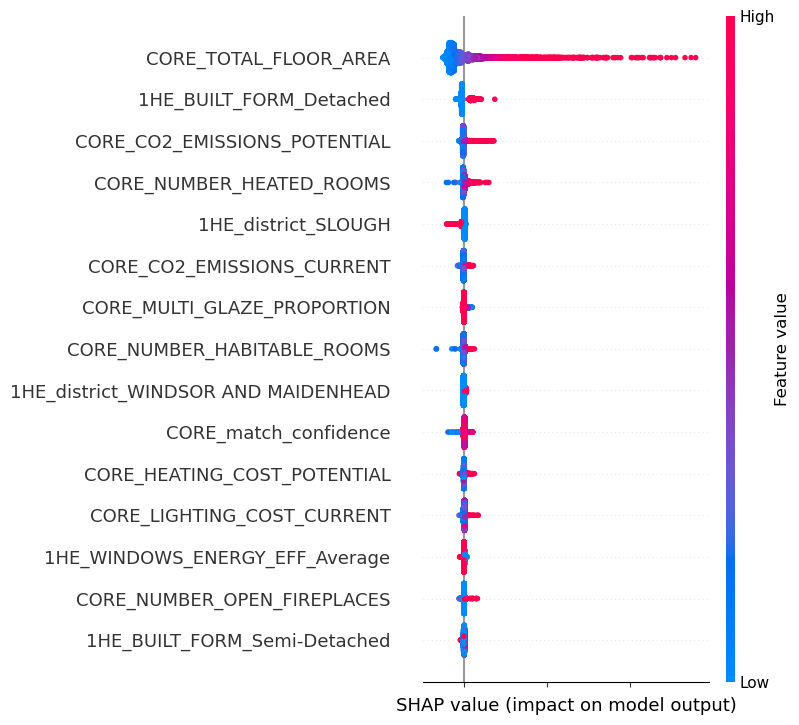

In [138]:
# Finding out which features are kept after the feature_selection step of the pipeline
X_test_transformed = XG_tuned_pipeline[:-1].transform(X_test)

def getPipelineFeatures(pipeline):
    preprocessor = pipeline.named_steps['preprocessor']
    features = preprocessor.get_feature_names_out()
    
    if 'feature_selection' in pipeline.named_steps:
        selector = pipeline.named_steps['feature_selection']
        mask = selector.get_support()
        selected_features = [f for f,m in zip(features, mask) if m]
    else:
        selected_features = features
    
    cleaned_names = [name.split('__')[-1] for name in selected_features]
    
    return cleaned_names

feature_names = getPipelineFeatures(XG_tuned_pipeline)

# Explaining Model Predictions using SHAP
explainer = shap.TreeExplainer(XG_tuned_pipeline.named_steps['regressor'])
shap_values = explainer(X_test_transformed)
shap_values.feature_names = list(feature_names)

# Visualising
#shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)
#plt.figure(figsize=(12,10))
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    max_display=15,
    show=False
)
#shap.plots.waterfall(shap_values[0], max_display=10)

ax = plt.gca()
ax.set_xticklabels([]) # Removes Overlapping Annotations
#ax.set_xlabel("")

plt.show()

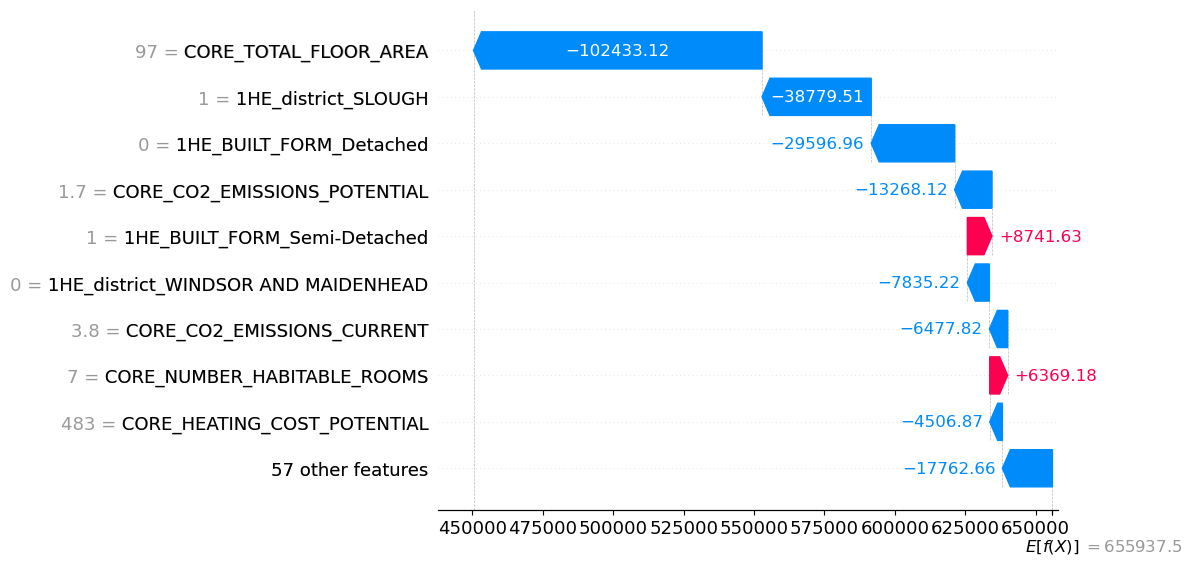

In [139]:
shap.plots.waterfall(shap_values[5], max_display=10,show=False)

ax = plt.gca()

for text in ax.texts:
    text.set_visible(False)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

In [ ]:
# Creating SHAP data for each district - Single Graph
shap_district_avg = []
shap_valid_districts = []
districts = features['1HE_district'].unique()

for district in districts:
    # Shap Values for the specific district
    name = f'shap_{district}' 
    mask = (X_test['1HE_district'] == district).values
    if mask.any():
        mean_shap = np.abs(shap_values[mask].values.mean(axis=0))
        shap_district_avg.append(mean_shap)
        shap_valid_districts.append(district)
    else:
        print(f"Skipping {district}: No data matching this criteria.")
        
shap_districts_df = pd.DataFrame(
    shap_district_avg, 
    index=shap_valid_districts, 
    columns=shap_values.feature_names
)
    
top_10_features = shap_districts_df.mean().sort_values(ascending=False).head(10).index
df_plot = shap_districts_df[top_10_features]
df_plot.head()

,CORE_TOTAL_FLOOR_AREA,1HE_BUILT_FORM_Detached,CORE_CO2_EMISSIONS_POTENTIAL,CORE_NUMBER_HEATED_ROOMS,CORE_match_confidence,CORE_CO2_EMISSIONS_CURRENT,CORE_HEATING_COST_POTENTIAL,CORE_NUMBER_HABITABLE_ROOMS,CORE_BUILDING_REFERENCE_NUMBER,CORE_NUMBER_OPEN_FIREPLACES
BUCKINGHAMSHIRE,51190.699219,16756.039062,2491.816895,4253.859375,967.243896,1431.101562,1066.792480,1897.725342,345.182281,85.278221
WYCOMBE,173217.484375,28404.509766,13254.940430,13733.965820,7177.058594,5997.060547,3846.205566,5681.125488,230.742554,1924.280151
SLOUGH,106596.898438,14594.500000,11163.868164,9219.650391,261.077820,5339.555176,3764.837158,4380.094238,116.524361,1638.071045
SOUTH BUCKS,1419.046875,32291.396484,14544.537109,8981.643555,2725.459961,8758.774414,4989.939453,1101.756470,1248.514893,4029.617676
SOUTH GLOUCESTERSHIRE,859816.125000,84646.703125,26905.056641,826.276550,20581.595703,46117.269531,23745.134766,19268.310547,21250.542969,2747.019775


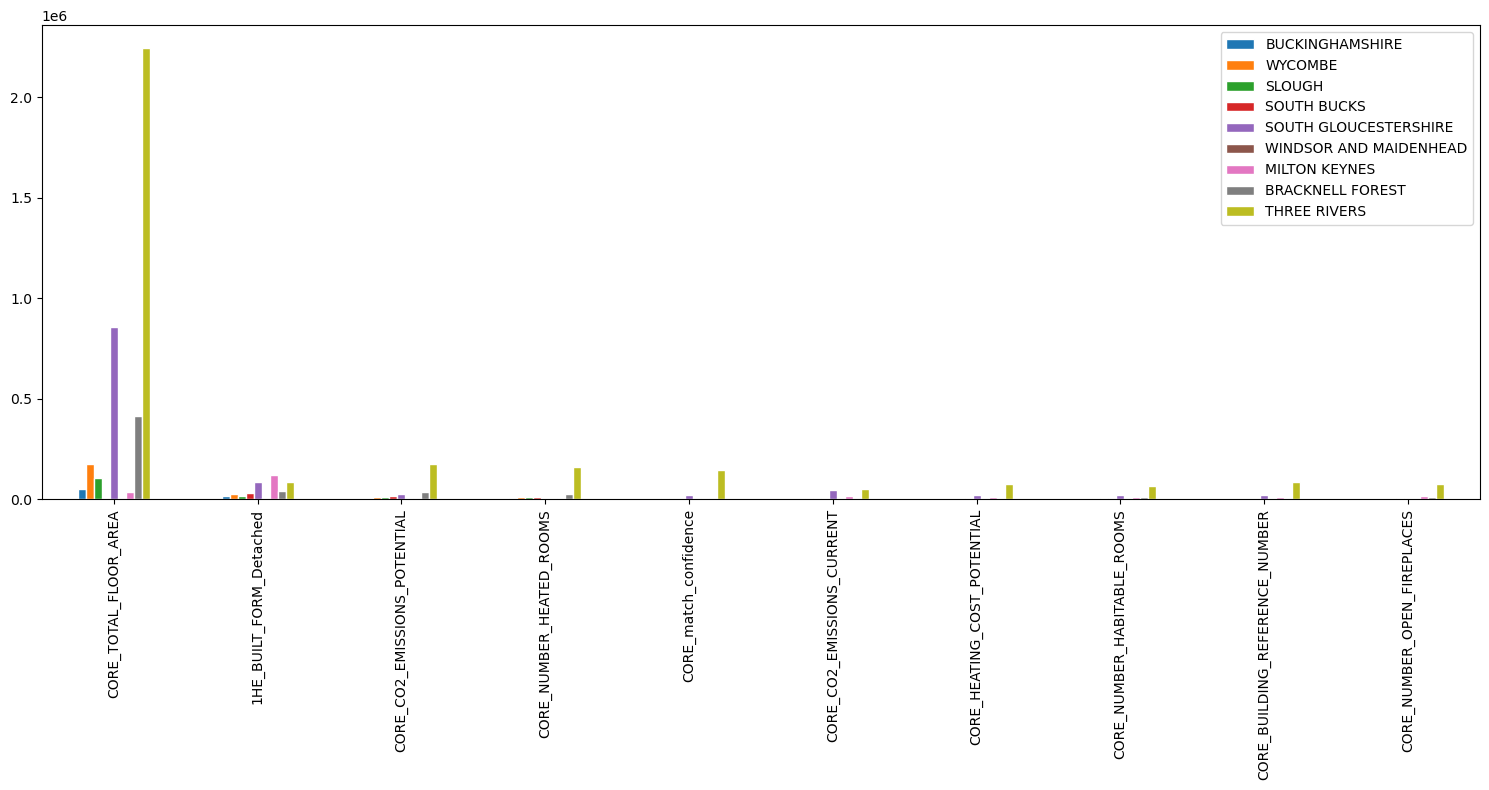

In [141]:
# Plotting the SHAP metrics by District
plt.close('all') # Wipes the residual effect from Matplotlib from previous graphs.
ax = df_plot.T.plot(kind='bar', figsize=(15,8), edgecolor = 'white')

plt.tight_layout()
plt.show()

In [142]:
df_plot.loc[:,df_plot.columns.str.startswith('1HE_district')]

""
BUCKINGHAMSHIRE
WYCOMBE
SLOUGH
SOUTH BUCKS
SOUTH GLOUCESTERSHIRE
WINDSOR AND MAIDENHEAD
MILTON KEYNES
BRACKNELL FOREST
THREE RIVERS


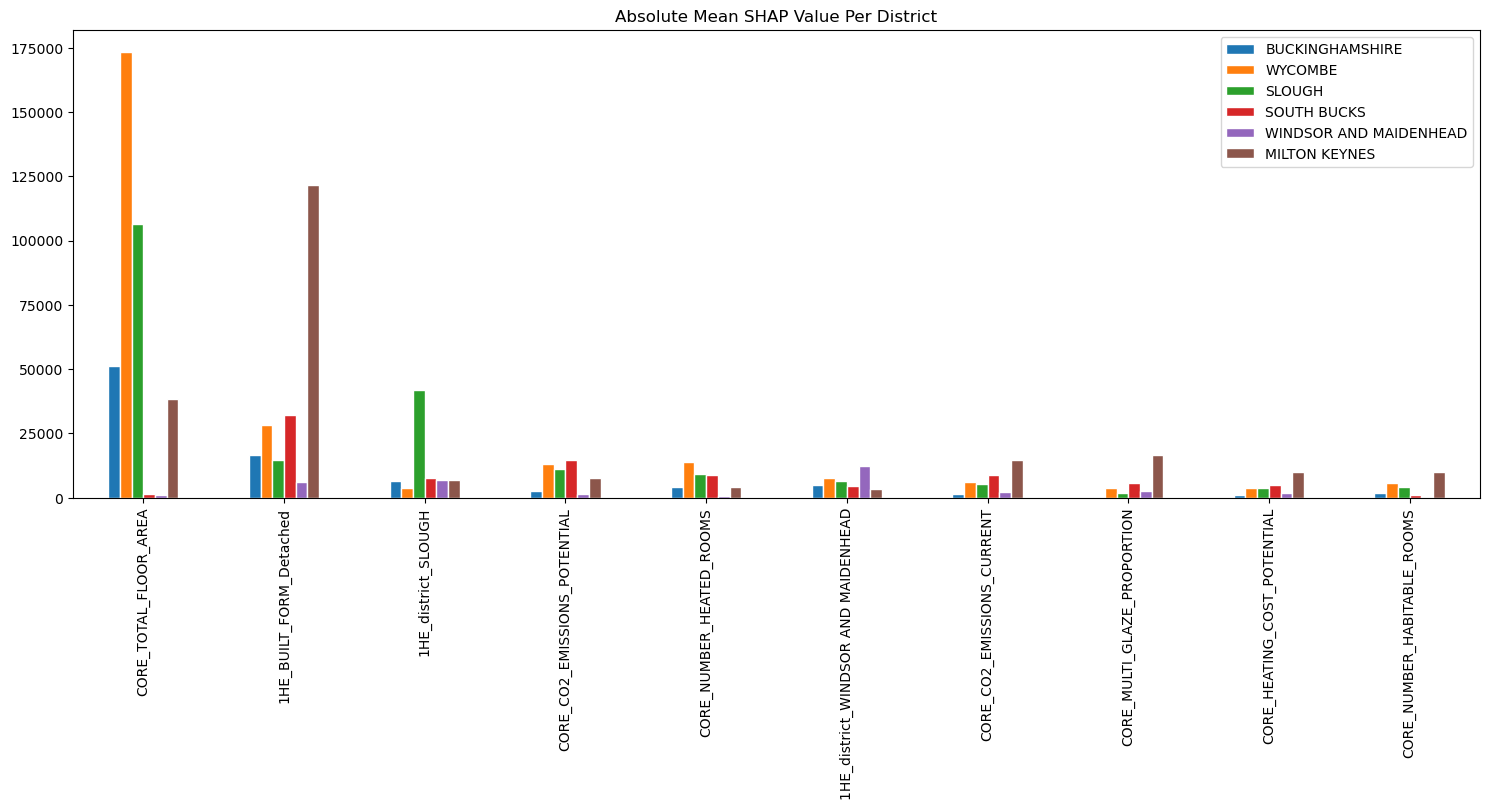

In [ ]:
# Removing the two districts with significant SHAP values for Floor Area (for better comparison)
rmv_districts = ['SOUTH GLOUCESTERSHIRE', 'THREE RIVERS', 'BRACKNELL FOREST']

shap_districts_df_filtered = shap_districts_df.drop(index = rmv_districts)

top_10_features = shap_districts_df_filtered.mean().sort_values(ascending=False).head(10).index
df_plot = shap_districts_df_filtered[top_10_features]

plt.close('all') # Wipes the residual effect from Matplotlib from previous graphs.
ax = df_plot.T.plot(kind='bar', figsize=(15,8), edgecolor = 'white')

plt.tight_layout()
plt.title('Absolute Mean SHAP Value Per District')
plt.savefig('img-outputs/SHAP_District_Comparison.png')
plt.show()